In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
from infomap import Infomap
import folium
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [28]:
air_2023 = pd.read_csv("/Users/arianeyu/Desktop/DSC_291/Dataset/T100D_SEGMENT_US_CARRIER_2023.csv")
air_2024 = pd.read_csv("/Users/arianeyu/Desktop/DSC_291/Dataset/T100D_SEGMENT_US_CARRIER_2024.csv")

airport_coords = pd.read_csv("/Users/arianeyu/Desktop/DSC_291/Dataset/iata-icao.csv")

/var/folders/w1/vc3f0wy917q9_qnbxvz9gvfh0000gn/T/ipykernel_92722/300272335.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  air_2023 = pd.read_csv("/Users/arianeyu/Desktop/DSC_291/Dataset/T100D_SEGMENT_US_CARRIER_2023.csv")
/var/folders/w1/vc3f0wy917q9_qnbxvz9gvfh0000gn/T/ipykernel_92722/300272335.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  air_2024 = pd.read_csv("/Users/arianeyu/Desktop/DSC_291/Dataset/T100D_SEGMENT_US_CARRIER_2024.csv")


In [ ]:
# total number of airports
len(set(np.concatenate([air_2023['ORIGIN'].unique(), air_2023['DEST'].unique(),air_2024['ORIGIN'].unique(), air_2024['DEST'].unique()])))

1520

In [3]:
air_2023['DEPARTURES_SCHEDULED'].value_counts()

0.0      92955
1.0      48823
2.0      22163
3.0      16196
4.0      16191
         ...  
516.0        1
370.0        1
498.0        1
380.0        1
377.0        1
Name: DEPARTURES_SCHEDULED, Length: 488, dtype: int64

In [33]:
air_2023

DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED    PAYLOAD   SEATS  \
0                        0.0                   0.0        0.0     0.0   
1                        0.0                   0.0        0.0     0.0   
2                        0.0                   0.0        0.0     0.0   
3                        0.0                   0.0        0.0     0.0   
4                        0.0                   0.0        0.0     0.0   
...                      ...                   ...        ...     ...   
424331                 855.0                 855.0  1026000.0  4481.0   
424332                 860.0                 860.0  1032000.0  4483.0   
424333                 870.0                 870.0  1044000.0  4536.0   
424334                 875.0                 875.0  1050000.0  4547.0   
424335                 875.0                 875.0  1050000.0  4547.0   

        PASSENGERS  FREIGHT  MAIL  DISTANCE  RAMP_TO_RAMP  AIR_TIME  ...  \
0              0.0      0.0   0.0       0.0           0.0       0.0  ...   
1              0.0      0.0   0.0      16.0           0.0       0.0  ...   
2              0.0      0.0   0.0      17.0           0.0       0.0  ...   
3              0.0      0.0   0.0      17.0           0.0       0.0  ...   
4              0.0      0.0   0.0      17.0           0.0       0.0  ...   
...            ...      ...   ...       ...           ...       ...  ...   
424331      2344.0   2380.0   0.0      11.0       10139.0    7574.0  ...   
424332      2348.0  14473.0   0.0      11.0       11790.0    9210.0  ...   
424333      2223.0   2654.0   0.0      11.0       10228.0    7618.0  ...   
424334      2382.0  14878.0   0.0      11.0       11890.0    9265.0  ...   
424335      2430.0   2394.0   0.0      11.0       10921.0    8296.0  ...   

                                         DEST_STATE_NM  DEST_WAC  \
0                                         Pennsylvania        23   
1                                        Massachusetts        13   
2                                           California        91   
3                                         Rhode Island        15   
4                                         Rhode Island        15   
...                                                ...       ...   
424331  U.S. Pacific Trust Territories and Possessions         5   
424332  U.S. Pacific Trust Territories and Possessions         5   
424333  U.S. Pacific Trust Territories and Possessions         5   
424334  U.S. Pacific Trust Territories and Possessions         5   
424335  U.S. Pacific Trust Territories and Possessions         5   

       AIRCRAFT_GROUP AIRCRAFT_TYPE AIRCRAFT_CONFIG  YEAR QUARTER  MONTH  \
0                   6           626               2  2023       3      8   
1                   6           622               1  2023       4     10   
2                   6           622               1  2023       4     10   
3                   0            79               1  2023       1      1   
4                   0            79               1  2023       2      5   
...               ...           ...             ...   ...     ...    ...   
424331              0            79               1  2023       3      7   
424332              0            79               1  2023       3      8   
424333              0            79               1  2023       3      8   
424334              0            79               1  2023       1      3   
424335              0            79               1  2023       1      3   

        DISTANCE_GROUP  CLASS  
0                    1      G  
1                    1      L  
2                    1      L  
3                    1      F  
4                    1      F  
...                ...    ...  
424331               1      F  
424332               1      F  
424333               1      F  
424334               1      F  
424335               1      F  

[424336 rows x 45 columns]

In [32]:
air_2024

DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED    PAYLOAD   SEATS  \
0                        0.0                   0.0        0.0     0.0   
1                        0.0                   0.0        0.0     0.0   
2                        0.0                   0.0        0.0     0.0   
3                        0.0                   0.0        0.0     0.0   
4                        0.0                   0.0        0.0     0.0   
...                      ...                   ...        ...     ...   
437310                 989.0                 987.0  2902800.0  8892.0   
437311                 995.0                 994.0  2737200.0  8946.0   
437312                 999.0                 998.0  2748200.0  8991.0   
437313                1522.0                1522.0  1826400.0  8026.0   
437314                1574.0                1574.0  1888800.0  8284.0   

        PASSENGERS  FREIGHT  MAIL  DISTANCE  RAMP_TO_RAMP  AIR_TIME  ...  \
0              0.0      0.0   0.0      15.0           0.0       0.0  ...   
1              0.0      0.0   0.0      17.0           0.0       0.0  ...   
2              0.0      0.0   0.0      17.0           0.0       0.0  ...   
3              0.0      0.0   0.0      17.0           0.0       0.0  ...   
4              0.0      0.0   0.0      17.0           0.0       0.0  ...   
...            ...      ...   ...       ...           ...       ...  ...   
437310      5602.0   8038.0   0.0      59.0       38105.0   28285.0  ...   
437311      7247.0  10718.0   0.0      59.0       37921.0   27463.0  ...   
437312      6631.0   5663.0   0.0      59.0       39218.0   30137.0  ...   
437313      5084.0  10340.0   0.0      11.0       17768.0   13202.0  ...   
437314      5104.0  29100.0   0.0      11.0       20390.0   15668.0  ...   

                                         DEST_STATE_NM  DEST_WAC  \
0                                             Illinois        41   
1                                         Rhode Island        15   
2                                         Rhode Island        15   
3                                         Rhode Island        15   
4                                         Rhode Island        15   
...                                                ...       ...   
437310                                          Alaska         1   
437311                                          Alaska         1   
437312                                          Alaska         1   
437313  U.S. Pacific Trust Territories and Possessions         5   
437314  U.S. Pacific Trust Territories and Possessions         5   

       AIRCRAFT_GROUP AIRCRAFT_TYPE AIRCRAFT_CONFIG  YEAR QUARTER  MONTH  \
0                   6           622               1  2024       4     10   
1                   0            79               1  2024       1      1   
2                   0            79               1  2024       3      7   
3                   0            79               1  2024       3      8   
4                   0            79               1  2024       4     12   
...               ...           ...             ...   ...     ...    ...   
437310              4           416               1  2024       3      8   
437311              4           416               1  2024       3      7   
437312              4           416               1  2024       3      7   
437313              0            79               1  2024       3      7   
437314              0            79               1  2024       3      7   

        DISTANCE_GROUP  CLASS  
0                    1      L  
1                    1      F  
2                    1      F  
3                    1      F  
4                    1      F  
...                ...    ...  
437310               1      F  
437311               1      F  
437312               1      F  
437313               1      F  
437314               1      F  

[437315 rows x 45 columns]

In [5]:
airport_coords

country_code         region_name iata  icao  \
0              AE            Abu Zaby  AAN  OMAL   
1              AE            Abu Zaby  AUH  OMAA   
2              AE            Abu Zaby  AYM   NaN   
3              AE            Abu Zaby  AZI  OMAD   
4              AE            Abu Zaby  DHF  OMAM   
...           ...                 ...  ...   ...   
9153           ZW            Masvingo  MVZ  FVMV   
9154           ZW  Matabeleland North  HWN  FVWN   
9155           ZW  Matabeleland North  VFA  FVFA   
9156           ZW  Matabeleland North  WKI  FVWT   
9157           ZW            Midlands  GWE  FVTL   

                              airport  latitude  longitude  
0        Al Ain International Airport   24.2617    55.6092  
1     Abu Dhabi International Airport   24.4330    54.6511  
2            Yas Island Seaplane Base   24.4670    54.6103  
3         Al Bateen Executive Airport   24.4283    54.4581  
4                  Al Dhafra Air Base   24.2482    54.5477  
...                               ...       ...        ...  
9153                 Masvingo Airport  -20.0553    30.8591  
9154     Hwange National Park Airport  -18.6299    27.0210  
9155           Victoria Falls Airport  -18.0959    25.8390  
9156              Hwange Town Airport  -18.3630    26.5198  
9157               Thornhill Air Base  -19.4364    29.8619  

[9158 rows x 7 columns]

In [6]:
air_2023[air_2023.columns[13]].unique()

array([6052, 1260, 6924, 7021, 6689, 1159, 1130, 6967, 6912, 16917, 1180,
       6970, 6992, 1212, 6965, 6997, 6981, 6927, 1289, 6999, 1267, 1205,
       6985, 6995, 1169, 1288, 6968, 1234, 6942, 6971, 6983, 1269, 1931,
       1230, 1241, 6980, 1229, 1189, 1175, 1199, 6940, 6860, 1203, 1235,
       11057, 1126, 1168, '06992', '01289', '01168', '01269', '01234',
       '01175', '06942', '06965', '01235', '01230', '06997', '01180',
       '06860', '01291', '01223', '01162', '11057', '01189', '01126',
       '06019', '06995', '06912', '01202', '01229', '06989', '06888',
       '07024', '06565', '0A875', '01130', '16565', '06689', '06580',
       '07041', '01260', '06820', '06003', '06055', '06774', '06673',
       '01268', '10876', '11054', '06035', '05375', '06721', '11041',
       '06031', '06725', '11033', '01146', '06076', '16076', '16144',
       '06144', '06795', '0A050', '01287', '19768', '07029', '16673',
       '10874', '11062', '11040', '06699', '10260', '10877', '16070',
      

In [7]:
air_2023.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER',
       'MONTH', 'DISTANCE_GROUP', 'CLASS'],
      dtype='object')

In [8]:
air_2023['UNIQUE_CARRIER'].nunique()

106

In [9]:
air_2023['UNIQUE_CARRIER_NAME'].nunique()

106

In [10]:
air_2023[['DEPARTURES_SCHEDULED','DEPARTURES_PERFORMED']].diff()['DEPARTURES_SCHEDULED'].value_counts()

0.0     423848
1.0        416
2.0         25
5.0         10
3.0          9
4.0          6
7.0          3
6.0          3
10.0         3
16.0         2
13.0         2
8.0          2
41.0         1
17.0         1
11.0         1
12.0         1
14.0         1
70.0         1
Name: DEPARTURES_SCHEDULED, dtype: int64

In [11]:
air_2023[(air_2023['PASSENGERS'] >= air_2023['SEATS']) & (air_2023['PASSENGERS'] > 0) | air_2023['DEPARTURES_PERFORMED'] > air_2023['DEPARTURES_SCHEDULED']]

DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED   PAYLOAD   SEATS  \
187                     0.0                   1.0       0.0     0.0   
188                     0.0                   1.0       0.0     0.0   
189                     0.0                   1.0       0.0     0.0   
190                     0.0                   1.0       0.0     0.0   
191                     0.0                   1.0       0.0     0.0   
...                     ...                   ...       ...     ...   
92950                   0.0                 295.0  649000.0  2950.0   
92951                   0.0                 295.0  649000.0  2950.0   
92952                   0.0                 300.0  660000.0  3000.0   
92953                   0.0                 304.0  668800.0  3040.0   
92954                   0.0                 491.0    8540.0     0.0   

       PASSENGERS  FREIGHT  MAIL  DISTANCE  RAMP_TO_RAMP  AIR_TIME  ...  \
187           0.0      0.0   0.0     230.0          80.0      42.0  ...   
188           0.0      0.0   0.0     230.0          80.0      51.0  ...   
189           0.0      0.0   0.0     256.0          70.0      50.0  ...   
190           0.0      0.0   0.0     268.0          75.0      55.0  ...   
191           0.0      0.0   0.0     318.0          90.0      55.0  ...   
...           ...      ...   ...       ...           ...       ...  ...   
92950      2230.0      0.0   0.0      70.0       11800.0   11505.0  ...   
92951      2231.0      0.0   0.0      70.0       11800.0   11505.0  ...   
92952      2216.0      0.0   0.0      70.0       12000.0   11700.0  ...   
92953      2239.0      0.0   0.0      70.0       12160.0   11856.0  ...   
92954         0.0   8540.0   0.0      68.0       22095.0   19640.0  ...   

             DEST_STATE_NM  DEST_WAC AIRCRAFT_GROUP AIRCRAFT_TYPE  \
187              Tennessee        54              6           614   
188               Kentucky        52              6           614   
189               Kentucky        52              6           614   
190           Pennsylvania        23              6           614   
191               Kentucky        52              6           617   
...                    ...       ...            ...           ...   
92950              Florida        33              0            42   
92951              Florida        33              0            42   
92952              Florida        33              0            42   
92953              Florida        33              0            42   
92954  U.S. Virgin Islands         4              1           131   

      AIRCRAFT_CONFIG  YEAR QUARTER  MONTH  DISTANCE_GROUP  CLASS  
187                 2  2023       2      5               1      L  
188                 2  2023       2      5               1      L  
189                 2  2023       2      5               1      L  
190                 2  2023       2      5               1      L  
191                 2  2023       2      5               1      L  
...               ...   ...     ...    ...             ...    ...  
92950               4  2023       2      5               1      L  
92951               4  2023       2      5               1      L  
92952               4  2023       3      7               1      L  
92953               4  2023       3      7               1      L  
92954               1  2023       4     11               1      P  

[92768 rows x 45 columns]

In [104]:
air_2023['DEPARTURES_SCHEDULED'].value_counts()

0.0      92955
1.0      48823
2.0      22163
3.0      16196
4.0      16191
         ...  
516.0        1
370.0        1
498.0        1
380.0        1
377.0        1
Name: DEPARTURES_SCHEDULED, Length: 488, dtype: int64

In [97]:
air_2023

DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED    PAYLOAD   SEATS  \
0                        0.0                   0.0        0.0     0.0   
1                        0.0                   0.0        0.0     0.0   
2                        0.0                   0.0        0.0     0.0   
3                        0.0                   0.0        0.0     0.0   
4                        0.0                   0.0        0.0     0.0   
...                      ...                   ...        ...     ...   
424331                 855.0                 855.0  1026000.0  4481.0   
424332                 860.0                 860.0  1032000.0  4483.0   
424333                 870.0                 870.0  1044000.0  4536.0   
424334                 875.0                 875.0  1050000.0  4547.0   
424335                 875.0                 875.0  1050000.0  4547.0   

        PASSENGERS  FREIGHT  MAIL  DISTANCE  RAMP_TO_RAMP  AIR_TIME  ...  \
0              0.0      0.0   0.0       0.0           0.0       0.0  ...   
1              0.0      0.0   0.0      16.0           0.0       0.0  ...   
2              0.0      0.0   0.0      17.0           0.0       0.0  ...   
3              0.0      0.0   0.0      17.0           0.0       0.0  ...   
4              0.0      0.0   0.0      17.0           0.0       0.0  ...   
...            ...      ...   ...       ...           ...       ...  ...   
424331      2344.0   2380.0   0.0      11.0       10139.0    7574.0  ...   
424332      2348.0  14473.0   0.0      11.0       11790.0    9210.0  ...   
424333      2223.0   2654.0   0.0      11.0       10228.0    7618.0  ...   
424334      2382.0  14878.0   0.0      11.0       11890.0    9265.0  ...   
424335      2430.0   2394.0   0.0      11.0       10921.0    8296.0  ...   

                                         DEST_STATE_NM  DEST_WAC  \
0                                         Pennsylvania        23   
1                                        Massachusetts        13   
2                                           California        91   
3                                         Rhode Island        15   
4                                         Rhode Island        15   
...                                                ...       ...   
424331  U.S. Pacific Trust Territories and Possessions         5   
424332  U.S. Pacific Trust Territories and Possessions         5   
424333  U.S. Pacific Trust Territories and Possessions         5   
424334  U.S. Pacific Trust Territories and Possessions         5   
424335  U.S. Pacific Trust Territories and Possessions         5   

       AIRCRAFT_GROUP AIRCRAFT_TYPE AIRCRAFT_CONFIG  YEAR QUARTER  MONTH  \
0                   6           626               2  2023       3      8   
1                   6           622               1  2023       4     10   
2                   6           622               1  2023       4     10   
3                   0            79               1  2023       1      1   
4                   0            79               1  2023       2      5   
...               ...           ...             ...   ...     ...    ...   
424331              0            79               1  2023       3      7   
424332              0            79               1  2023       3      8   
424333              0            79               1  2023       3      8   
424334              0            79               1  2023       1      3   
424335              0            79               1  2023       1      3   

        DISTANCE_GROUP  CLASS  
0                    1      G  
1                    1      L  
2                    1      L  
3                    1      F  
4                    1      F  
...                ...    ...  
424331               1      F  
424332               1      F  
424333               1      F  
424334               1      F  
424335               1      F  

[424336 rows x 45 columns]

In [71]:
air_2024.shape

(437315, 45)

## Communities

In [12]:
# Create a directed graph
G_2023 = nx.DiGraph()

# Add edges representing flights
for _, row in air_2023.iterrows():
    origin = row["ORIGIN"]
    dest = row["DEST"]
    weight = row["DEPARTURES_PERFORMED"]  # Use number of performed departures as edge weight
    
    if G_2023.has_edge(origin, dest):
        G_2023[origin][dest]["weight"] += weight
    else:
        G_2023.add_edge(origin, dest, weight=weight)


In [13]:
# Create a directed graph
G_2024 = nx.DiGraph()

# Add edges representing flights
for _, row in air_2024.iterrows():
    origin = row["ORIGIN"]
    dest = row["DEST"]
    weight = row["DEPARTURES_PERFORMED"]  # Use number of performed departures as edge weight
    
    if G_2024.has_edge(origin, dest):
        G_2024[origin][dest]["weight"] += weight
    else:
        G_2024.add_edge(origin, dest, weight=weight)


In [14]:

def run_infomap_igraph(G):
    nodes = list(G.nodes())
    node_to_index = {node: i for i, node in enumerate(nodes)}
    edge_list = [(node_to_index[u], node_to_index[v]) for u, v in G.edges()]
    weights = [data.get("weight", 1) for _, _, data in G.edges(data=True)]
    
    ig_graph = ig.Graph(directed=True)
    ig_graph.add_vertices(len(nodes))
    ig_graph.add_edges(edge_list)
    ig_graph.es['weight'] = weights

    communities = ig_graph.community_infomap(edge_weights="weight")
    membership = communities.membership
    node_membership = {node: membership[i] for node, i in node_to_index.items()}
    
    # Calculate modularity (note: modularity is originally for undirected graphs)
    mod_value = ig_graph.modularity(membership, weights=ig_graph.es["weight"])
    print("Modularity:", mod_value)
    
    return node_membership, ig_graph


Modularity: 0.13166267193073622
Major Communities: {0: ['PHL', 'BOS', 'LGB', 'LAX', 'SNA', 'MTJ', 'GUC', 'STL', 'UIN', 'SJU', 'PWM', 'CLE', 'PIT', 'SAN', 'CMH', 'SBN', 'LAN', 'COS', 'RDU', 'CLT', 'TYS', 'ATL', 'PHX', 'YUM', 'JFK', 'OKC', 'DAL', 'BWI', 'SHV', 'IAH', 'NGU', 'SAV', 'ORD', 'IAD', 'MSP', 'MSN', 'LAS', 'BUF', 'GRB', 'DTW', 'SLC', 'BZN', 'ADW', 'PVD', 'GPT', 'CVG', 'SMF', 'EWR', 'OAK', 'IND', 'TUS', 'MKE', 'MKC', 'MCI', 'MSY', 'TPA', 'AEX', 'LIT', 'SAT', 'BTR', 'GNV', 'LGA', 'MEM', 'BNA', 'MDW', 'FOE', 'SCE', 'ELP', 'MIA', 'DEN', 'MCO', 'PIE', 'AZA', 'AUS', 'PVU', 'SFB', 'HRL', 'FLL', 'HOU', 'HIF', 'SEA', 'GRK', 'RNO', 'GSO', 'RIC', 'PLN', 'PBI', 'FHB', 'FSM', 'DHN', 'ICT', 'AFW', 'BLI', 'HVN', 'MRY', 'SFO', 'FAT', 'C01', 'BUR', 'LVK', 'SJC', 'ABQ', 'SUN', 'SAF', 'COD', 'GEG', 'PSP', 'SBP', 'MEV', 'STS', 'BIH', 'PDX', 'JAC', 'SGU', 'BFL', 'TEX', 'FLG', 'HWD', 'RDM', 'OMA', 'AZO', 'CAK', 'PRB', 'ONT', 'ASE', 'GRR', 'SOW', 'LGU', 'TUL', 'CCR', 'MFR', 'TWF', 'EGE', 'BJC', 'FCA',

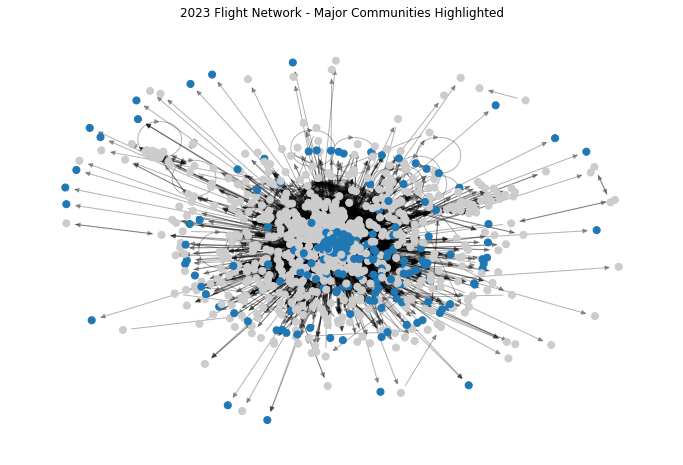

In [15]:
communities_2023_ig, ig_graph_2023 = run_infomap_igraph(G_2023)

# --- Group nodes by community --- #
grouped_communities_2023 = defaultdict(list)
for node, comm in communities_2023_ig.items():
    grouped_communities_2023[comm].append(node)

# Define a threshold for "major" communities (e.g., at least 10 nodes)
threshold = 100
major_comms_2023 = {comm: nodes for comm, nodes in grouped_communities_2023.items() if len(nodes) >= threshold}
print("Major Communities:", major_comms_2023)

# --- Visualize the major communities in NetworkX --- #
# Create a color map for communities
color_map = {}
colors = plt.cm.tab20.colors  # get a list of colors
for i, comm in enumerate(major_comms_2023):
    for node in major_comms_2023[comm]:
        color_map[node] = colors[i % len(colors)]

# Set node colors: major communities get a color; minor communities as gray
node_colors = []
for node in G_2023.nodes():
    node_colors.append(color_map.get(node, (0.8, 0.8, 0.8)))  # gray for minor communities

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_2023, k=0.15, seed=42)  # or use another layout
nx.draw_networkx_nodes(G_2023, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_2023, pos, alpha=0.3)
plt.title("2023 Flight Network - Major Communities Highlighted")
plt.axis("off")
plt.show()


Modularity: 0.13216115552450308
Major Communities: {0: ['ORD', 'MDW', 'EWR', 'JFK', 'BOS', 'PVC', 'IAD', 'BWI', 'PVD', 'MKE', 'PHL', 'PWM', 'TYS', 'BNA', 'MBL', 'TPA', 'MIA', 'ATL', 'SVN', 'LAS', 'BUR', 'CLT', 'LAX', 'PHX', 'PIT', 'SDF', 'DTW', 'IND', 'FAY', 'MSP', 'GPT', 'DEN', 'SLC', 'CLE', 'MKC', 'MSY', 'DAL', 'AEX', 'MCO', 'RDU', 'YUM', 'CVG', 'SFO', 'SJC', 'IAH', 'MSN', 'PDX', 'CMI', 'GRB', 'HOU', 'LGB', 'RIV', 'SEA', 'PIE', 'FLL', 'MCI', 'BTR', 'ELP', 'MFE', 'MEM', 'CMH', 'SMF', 'AFW', 'SJU', 'SAC', 'FAT', 'TUS', 'HVN', 'STS', 'ISP', 'BTV', 'MRY', 'BGR', 'SAN', 'SNA', 'BFL', 'PRB', 'SBA', 'OXR', 'RNO', 'OGD', 'SGU', 'OAK', 'PSP', 'SAF', 'ABQ', 'COS', 'JAC', 'LNK', 'DSM', 'MHR', 'TUL', 'OMA', 'CCR', 'RDM', 'RST', 'EGE', 'CHA', 'SUN', 'BZN', 'COD', 'MSO', 'AUS', 'MYF', 'FTW', 'SAT', 'EUG', 'SBD', 'ONT', 'FLG', 'CNY', 'LBF', 'GUP', 'PRC', 'ROW', 'ASE', 'FCA', 'EAR', 'RBD', 'HII', 'GTF', 'PVU', 'FNL', 'EKO', 'RAP', 'SHR', 'SCK', 'HOB', 'MVW', 'SGF', 'CLM', 'TWF', 'SBP', 'MAF', 'IDA',

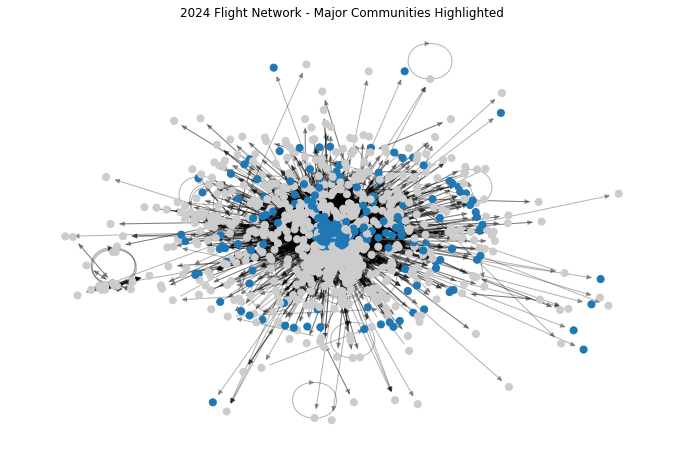

In [16]:
communities_2024_ig, ig_graph_2024 = run_infomap_igraph(G_2024)

# --- Group nodes by community --- #
grouped_communities_2024 = defaultdict(list)
for node, comm in communities_2024_ig.items():
    grouped_communities_2024[comm].append(node)

# Define a threshold for "major" communities (e.g., at least 10 nodes)
threshold = 100
major_comms_2024 = {comm: nodes for comm, nodes in grouped_communities_2024.items() if len(nodes) >= threshold}
print("Major Communities:", major_comms_2024)

# --- Visualize the major communities in NetworkX --- #
# Create a color map for communities
color_map = {}
colors = plt.cm.tab20.colors  # get a list of colors
for i, comm in enumerate(major_comms_2024):
    for node in major_comms_2024[comm]:
        color_map[node] = colors[i % len(colors)]

# Set node colors: major communities get a color; minor communities as gray
node_colors = []
for node in G_2024.nodes():
    node_colors.append(color_map.get(node, (0.8, 0.8, 0.8)))  # gray for minor communities

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_2024, k=0.15, seed=42)  # or use another layout
nx.draw_networkx_nodes(G_2024, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_2024, pos, alpha=0.3)
plt.title("2024 Flight Network - Major Communities Highlighted")
plt.axis("off")
plt.show()


In [ ]:
# Assume `major_airports` is the list of airport codes in your major community.
# For example, if you found a community with 522 airports, you might have:
major_airports_2023 = list(major_comms_2023[0])  # Replace community_id with the correct key from your communities dictionary

# Filter the coordinate DataFrame to only include airports from the major community.
major_airports_data = airport_coords[airport_coords['iata'].isin(major_airports_2023)]

# Create a folium map centered on the U.S.
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Plot each airport as a marker on the map.
for idx, row in major_airports_data.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,  # adjust marker size as needed
        popup=row["iata"],
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(us_map)

# Save the map to an HTML file and display it
us_map


In [ ]:

# Load the airport coordinates data.
# This CSV should contain the latitude and longitude for each airport.

# Assume `major_airports` is the list of airport codes in your major community.
# For example, if you found a community with 522 airports, you might have:
major_airports_2023 = list(major_comms_2023[0])  # Replace community_id with the correct key from your communities dictionary
major_airports_2024 = list(major_comms_2024[0])

# Create a folium map centered on the U.S.
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

us_airport_coords = airport_coords[airport_coords['country_code'] == "US"]
for idx, row in us_airport_coords.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    code = row["iata"]
    
    # Choose color: red if the airport is in the major community, else blue.
    if code in major_airports_2023 and code in major_airports_2024:
        marker_color = "purple"
    elif code in major_airports_2023:
        marker_color = "blue"
    elif code in major_airports_2024:
        marker_color = "red"
    else:
        marker_color = "grey"
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,            # Adjust size as needed.
        popup=code,
        color=marker_color,
        fill_color=marker_color,
        fill_opacity=0.8
    ).add_to(us_map)

# Save the map to an HTML file and display it
us_map


Infomap Algorithm

What It Does:
Infomap takes a different approach by using concepts from information theory. It models a random walker navigating through the network and then looks for groups of nodes (communities) where the walker tends to stay longer before moving to another group. The goal is to compress the description of the random walk through these communities, which naturally reveals the community structure.

How It Works:

Random Walk Simulation: The algorithm simulates the movement of a random walker across nodes.
Map Equation: It uses the map equation, an information-theoretic measure, to quantify how well a given community structure compresses the description of the random walk.
Optimization: The algorithm then adjusts community assignments to minimize the description length (i.e., to make the code as concise as possible), which implies a strong community structure.
Characteristics:

Suitability for Directed Graphs: Infomap naturally handles directed and weighted graphs, which is beneficial for your flight network data where the direction (from ORIGIN to DEST) is important.
Flow-Based Insight: Since Infomap is based on the idea of flows (like flights moving between airports), it might be particularly well-suited for detecting geographical clusters or hotspots of congestion in your network.


When you see that the nodes are evenly distributed across the U.S., it suggests that the community detection algorithm has grouped together a set of airports that are highly interconnected—even if they're not geographically clustered. Here are some possible interpretations:

Core Network of Major Hubs:
The community might represent a "backbone" of the domestic air traffic network—a set of major airports that, despite being spread out geographically, are strongly interconnected due to high flight volumes. These airports can be seen as forming a central core or backbone that facilitates nationwide connectivity and, potentially, congestion at key hubs.

Hub-and-Spoke Structure:
Many airline networks operate on a hub-and-spoke model. In this case, the community could be capturing hubs and their primary spokes. Although the spokes (smaller, connecting airports) may be spread throughout the country, they all funnel into these hub airports, which can create strong connectivity despite the wide geographical spread.

Functional vs. Geographic Clustering:
Community detection via Infomap is based on the flow of flights (i.e., how frequently airports are connected) rather than geographical distance. Thus, even if airports are geographically distant, if they share high-traffic routes, they may end up in the same community. This means the community represents functional connectivity (i.e., shared patterns of congestion or flight volume) rather than geographic proximity.

Implications for Congestion Analysis:
If the major community includes many airports that are spread across the country, it could indicate that congestion issues are not isolated to a particular region but are part of a national pattern. This insight might prompt further investigation into how congestion at one hub affects or is affected by distant hubs due to interdependencies in the flight network.

In summary, while you expected geographical clusters, the evenly distributed nodes imply that the community represents a set of functionally connected airports—likely the high-traffic, major hubs—forming a critical backbone for the entire network. This information is still very valuable for analyzing and addressing congestion, as it points to key nodes that might be central to network-wide delays or inefficiencies.

Feel free to ask if you'd like more details or further visualizations to delve deeper into this interpretation!

Both approaches have their merits, but there are some key differences that might make one more appropriate than the other for your specific data and research goals:

Handling of Directionality:

community.best_partition / community.modularity (Louvain method): These functions are typically designed for undirected graphs. When working with directed networks, you would need to convert your graph into an undirected version, which may result in the loss of important directional flow information (like the specific paths flights take from origin to destination).
Infomap: It naturally handles directed, weighted graphs. Since your flight data is directional (from ORIGIN to DEST) and you care about flows (and possibly congestion), Infomap can capture the dynamics without forcing a conversion to undirected.
Algorithmic Approach:

Louvain (community.best_partition): This method optimizes a global modularity measure to detect communities. It’s very efficient and widely used, but its optimization is based on the assumption of undirected connections (unless adjusted), which might not fully capture the nuances of a directional flow system like air traffic.
Infomap: Uses an information-theoretic framework based on random walks. It finds communities by compressing the description of the flow in the network. This flow-based approach is particularly well-suited for networks where the pattern of movement (e.g., air travel routes) is key.
Interpretation and Application:

Louvain-based metrics: When you use community.best_partition and then compute a global community.modularity value, you're obtaining a single metric that summarizes the quality of the partitioning across the entire network. This is useful for comparing different partitions or networks but may not capture directed flow properties.
Infomap output: Provides community assignments that reflect the network’s inherent flow structure, which might offer deeper insights into congestion patterns and how airports interact based on actual flight paths.
In summary, you can use Louvain-based methods if you convert your graph to an undirected form or if direction is not critical for your analysis. However, since your data is directed and you’re interested in understanding the flow (which is key to air traffic and congestion analysis), Infomap is often more appropriate because it directly accommodates directed, weighted edges without losing the critical directional information.

## Spectral Clusteirng (Failed)

/Users/arianeyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral clustering labels: {'PHL': 0, 'PIT': 0, 'TEB': 0, 'FOK': 0, 'FRG': 0, 'MIA': 0, 'ROC': 0, 'HTO': 0, 'MQY': 0, 'MVY': 0, 'MCO': 0, 'BCT': 0, 'OPF': 0, 'DAL': 0, 'BLM': 0, 'MDW': 0, 'ACK': 0, 'SJU': 0, 'MLJ': 0, 'MRC': 0, 'STL': 0, 'BZN': 0, 'LAS': 0, 'HOU': 0, 'SLC': 0, 'TEX': 0, 'MSP': 0, 'HPN': 0, 'OIC': 0, 'BOS': 0, 'BVY': 0, 'ELM': 0, 'PWM': 0, 'BHB': 0, 'BED': 0, 'CMH': 0, 'VNY': 0, 'PBI': 0, 'IND': 0, 'BNA': 0, 'APF': 0, 'LAX': 0, 'BKG': 0, 'TBN': 0, 'TN8': 0, 'AOO': 0, 'OGS': 0, 'AUS': 0, 'BWI': 0, 'AGC': 0, 'CLT': 0, 'MCN': 0, 'MDH': 0, 'CPS': 0, 'SAT': 0, 'ALB': 0, 'ICT': 0, 'CTH': 0, 'LGA': 0, 'DCA': 0, 'JFK': 0, 'BTV': 0, 'PVD': 0, 'CVG': 0, 'BDL': 0, 'ORH': 0, 'MSY': 0, 'ORD': 0, 'CHO': 0, 'BFD': 0, 'CHS': 0, 'TUP': 0, 'LEX': 0, 'TPA': 0, 'GSP': 0, 'BPT': 0, 'CLE': 0, 'LUK': 0, 'GRK': 0, 'RDU': 0, 'EWR': 0, 'SDF': 0, 'GSO': 0, 'PSM': 0, 'CAK': 0, 'COS': 0, 'GRR': 0, 'BUF': 0, 'YIP': 0, 'BTR': 0, 'INT': 0, 'MEM': 0, 'ATL': 0, 'DTW': 0, 'MYR': 0, 'MKE': 0, 'LIT': 0, '

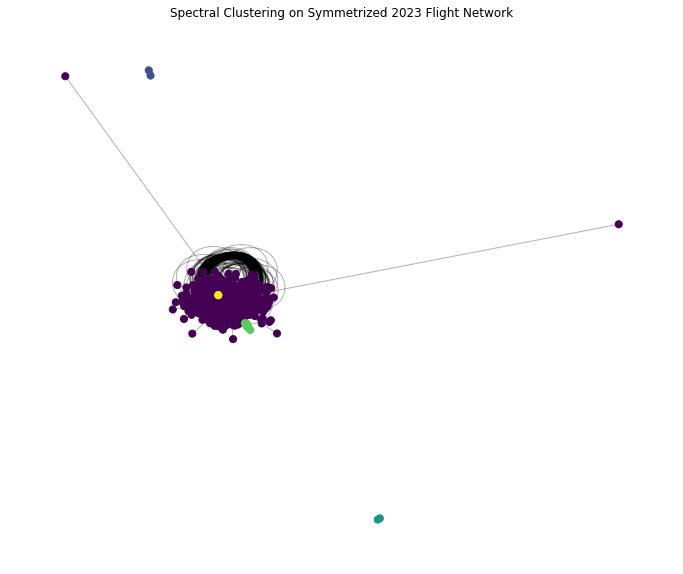

In [87]:
import networkx as nx
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Step 1: Symmetrize your directed graph (e.g., G_2023)
G_sym = nx.Graph()
for u, v, data in G_2023.edges(data=True):
    weight = data.get("weight", 1)
    # If an edge already exists, add the weight; otherwise, create it.
    if G_sym.has_edge(u, v):
        G_sym[u][v]["weight"] += weight
    else:
        G_sym.add_edge(u, v, weight=weight)

# Step 2: Create an adjacency matrix from the symmetrized graph.
# Ensure nodes are in a consistent order.
nodes = list(G_sym.nodes())
A = nx.to_numpy_array(G_sym, nodelist=nodes, weight="weight")

# Optionally, you might normalize the matrix here if needed.
# For example: A = A / A.max()

# Step 3: Perform spectral clustering.
# Set the number of clusters (you can experiment with this number)
n_clusters = 5

# Using the 'precomputed' affinity because A is our affinity matrix.
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = sc.fit_predict(A)

# Create a mapping from node to cluster label.
spectral_labels = {node: label for node, label in zip(nodes, labels)}
print("Spectral clustering labels:", spectral_labels)

# Step 4 (Optional): Visualize the clusters using networkx.
# Assign a color for each cluster.
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis', n_clusters)

# Create a color map for nodes based on their cluster labels.
node_colors = [cmap(spectral_labels[node]) for node in G_sym.nodes()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sym, seed=42)  # Choose a layout for visualization
nx.draw_networkx_nodes(G_sym, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_sym, pos, alpha=0.3)
plt.title("Spectral Clustering on Symmetrized 2023 Flight Network")
plt.axis("off")
plt.show()


In [91]:
dict={}
for key, label in spectral_labels.items():
    if label not in dict:
        dict[label] = [key]
    else:
        dict[label].append(key)

In [96]:
len(dict[0])

1331

What you're observing—one giant community containing most airports and several tiny ones—can indicate a couple of things:

Graph Structure:
Your symmetrized graph may be highly connected, meaning most airports are closely linked. In such cases, spectral clustering (and other clustering methods) might naturally detect one large "core" group with a few outliers or peripheral connections.

Parameter Sensitivity:
The spectral clustering algorithm is sensitive to the number of clusters you specify. Increasing the number of clusters (the n_clusters parameter) might force a finer split of the giant community, but that doesn't guarantee that the resulting subclusters will be meaningful or well-separated.

Affinity Matrix and Normalization:
How the affinity (adjacency) matrix is constructed and normalized can affect the clustering results. It might be helpful to experiment with different normalizations or even different methods for symmetrizing your directed graph.

Recommendations
Experiment with n_clusters:
Try a range of cluster numbers to see if a more balanced partition emerges. However, be cautious—forcing more clusters doesn't always lead to more interpretable or valid communities if the underlying network structure doesn't support them.

Evaluate Cluster Quality:
Consider using metrics such as silhouette scores or examining intra-cluster density versus inter-cluster connectivity (modularity, conductance) to assess the quality of the clustering. This will help you decide whether the splits are meaningful.

Alternative Approaches:
Given your data's characteristics, spectral clustering might not capture the inherent structure as well as a flow-based method (like Infomap) or even hierarchical clustering. Each method has its assumptions, and if the network is highly interconnected, many algorithms will tend to return one dominant cluster with some outliers.

In summary, the result might be more reflective of your network's structure than a failure of spectral clustering. It indicates that most airports are part of a large, interconnected group, with only a few outliers. However, you can experiment with increasing the number of clusters and adjusting the affinity matrix to see if more nuanced structure emerges.

# Congestion Prediction

In [28]:
(air_2023['SEATS'] > 0).sum()

378579

In [31]:
air_2023[air_2023['DEPARTURES_PERFORMED'] >  air_2023['DEPARTURES_SCHEDULED']]

DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED     PAYLOAD    SEATS  \
187                      0.0                   1.0         0.0      0.0   
188                      0.0                   1.0         0.0      0.0   
189                      0.0                   1.0         0.0      0.0   
190                      0.0                   1.0         0.0      0.0   
191                      0.0                   1.0         0.0      0.0   
...                      ...                   ...         ...      ...   
423903                 314.0                 318.0  15860480.0  62899.0   
423935                 321.0                 322.0  13974800.0  56350.0   
423940                 322.0                 332.0  14408800.0  58100.0   
423946                 323.0                 327.0  16274920.0  64916.0   
423955                 324.0                 326.0  16225160.0  64713.0   

        PASSENGERS  FREIGHT    MAIL  DISTANCE  RAMP_TO_RAMP  AIR_TIME  ...  \
187            0.0      0.0     0.0     230.0          80.0      42.0  ...   
188            0.0      0.0     0.0     230.0          80.0      51.0  ...   
189            0.0      0.0     0.0     256.0          70.0      50.0  ...   
190            0.0      0.0     0.0     268.0          75.0      55.0  ...   
191            0.0      0.0     0.0     318.0          90.0      55.0  ...   
...            ...      ...     ...       ...           ...       ...  ...   
423903     56590.0  17793.0  8008.0     270.0       21898.0   14047.0  ...   
423935     24736.0      0.0     0.0     100.0       13670.0    8309.0  ...   
423940     25052.0      0.0     0.0     100.0       14941.0    7550.0  ...   
423946     57839.0  77058.0  2910.0     404.0       28806.0   20051.0  ...   
423955     52443.0  87175.0     0.0     404.0       30039.0   20668.0  ...   

       DEST_WAC  AIRCRAFT_GROUP AIRCRAFT_TYPE AIRCRAFT_CONFIG  YEAR QUARTER  \
187          54               6           614               2  2023       2   
188          52               6           614               2  2023       2   
189          52               6           614               2  2023       2   
190          23               6           614               2  2023       2   
191          52               6           617               2  2023       2   
...         ...             ...           ...             ...   ...     ...   
423903       34               6           622               1  2023       3   
423935        2               6           838               1  2023       3   
423940        2               6           838               1  2023       3   
423946       33               6           622               1  2023       4   
423955       34               6           622               1  2023       4   

       MONTH  DISTANCE_GROUP  CLASS  CONGESTION  
187        5               1      L           1  
188        5               1      L           1  
189        5               1      L           1  
190        5               1      L           1  
191        5               1      L           1  
...      ...             ...    ...         ...  
423903     7               1      F           1  
423935     8               1      F           1  
423940     8               1      F           1  
423946    12               1      F           1  
423955    12               1      F           1  

[104202 rows x 46 columns]

In [ ]:
air_2023[air_2023['SEATS'] > 0]

In [21]:
# --- 1. Create the Congestion Label ---
# For congestion positive, the filter is:
# (PASSENGERS >= SEATS and PASSENGERS > 0) or (DEPARTURES_PERFORMED > DEPARTURES_SCHEDULED)
def label_congestion(df):
    condition = ((df['PASSENGERS'] >= df['SEATS']) & (df['PASSENGERS'] > 0)) | (df['DEPARTURES_PERFORMED'] > df['DEPARTURES_SCHEDULED'])
    df = df.copy()
    df['CONGESTION'] = condition.astype(int)  # 1 for positive, 0 for negative
    return df

# only flights with seats
air_2023 = label_congestion(air_2023[air_2023['SEATS'] > 0])
air_2024 = label_congestion(air_2024[air_2024['SEATS'] > 0])

# --- 2. Select Features and the Label ---
features = ['UNIQUE_CARRIER', 'AIR_TIME', 'AIRCRAFT_TYPE', 'MONTH', 'ORIGIN', 'DEST']
target = 'CONGESTION'

X_train = air_2023[features]
y_train = air_2023[target]

X_2024 = air_2024[features]
y_2024 = air_2024[target]

In [22]:
X_val, X_test, y_val, y_test = train_test_split(X_2024, y_2024, test_size=0.7, random_state=42)

In [23]:
# Here, 'AIR_TIME' and 'MONTH' are numerical; the rest are categorical.
categorical_features = ['UNIQUE_CARRIER', 'AIRCRAFT_TYPE', 'ORIGIN', 'DEST']
numerical_features = ['AIR_TIME', 'MONTH']

In [24]:
# Identify categorical and numerical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # This will pass numerical features without change.
)

In [25]:
# Build a pipeline with the preprocessor and the RandomForestClassifier.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['UNIQUE_CARRIER',
                                                   'AIRCRAFT_TYPE', 'ORIGIN',
                                                   'DEST'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [26]:
y_val_pred = pipeline.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Optionally, evaluate on the test set
y_test_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.9308798646362099
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     91619
           1       0.88      0.80      0.84     26581

    accuracy                           0.93    118200
   macro avg       0.91      0.88      0.90    118200
weighted avg       0.93      0.93      0.93    118200

Test Accuracy: 0.9306857818289933
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96    213781
           1       0.88      0.80      0.84     62021

    accuracy                           0.93    275802
   macro avg       0.91      0.88      0.90    275802
weighted avg       0.93      0.93      0.93    275802

